# Term Project: Wildfires

### Predictive Analytics
What areas do we predict the highest likelihood of fires in the following years? We will use the following [wildfire dataset](https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires) to predict where a wildfire is most likely to happen in the coming years.

### Import necessary libraries

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# import geopandas as gpd
# from shapely.geometry import Point
# import matplotlib.patches as mpatches
# from colour import Color
# from sklearn.neighbors import KernelDensity

## Read data from sqlite file

In [2]:
con = sqlite3.connect("../FPA_FOD_20170508.sqlite")

In [3]:
wildfires = pd.read_sql_query('SELECT * FROM Fires', con)

## Clean Wildfire Data

### Display first 5 rows and columns

In [4]:
print(f"Rows {wildfires.shape[0]} X Columns {wildfires.shape[1]}")

Rows 1880465 X Columns 39


In [5]:
wildfires.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


### Only care about Colorado. Filter data and drop STATE column

In [6]:
wildfires = wildfires[wildfires['STATE'] == "CO"]

In [7]:
wildfires.drop(['STATE'], axis=1, inplace=True)

In [8]:
print(f"Rows {wildfires.shape[0]} X Columns {wildfires.shape[1]}")

Rows 34157 X Columns 38


In [9]:
wildfires.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,COUNTY,FIPS_CODE,FIPS_NAME,Shape
47,48,48,FS-1418940,FED,FS-FIRESTAT,FS,USCOPSF,Pike and San Isabel National Forest,0212,Pike San Isabel National Forest,...,0.5,B,39.292222,-105.183056,5.0,USFS,None,None,None,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7KZ\xc0...
61,62,62,FS-1418976,FED,FS-FIRESTAT,FS,USCOPSF,Pike and San Isabel National Forest,0212,Pike San Isabel National Forest,...,0.2,A,38.913333,-105.983611,5.0,USFS,None,None,None,b'\x00\x01\xad\x10\x00\x00\xa8[\x03|\xf3~Z\xc0...
62,63,63,FS-1418978,FED,FS-FIRESTAT,FS,USCOPSF,Pike and San Isabel National Forest,0212,Pike San Isabel National Forest,...,0.1,A,39.100278,-106.367500,5.0,USFS,None,None,None,b'\x00\x01\xad\x10\x00\x00\xe8Q\xb8\x1e\x85\x9...
114,115,117,FS-1419150,FED,FS-FIRESTAT,FS,USCOPSF,Pike and San Isabel National Forest,0212,Pike San Isabel National Forest,...,80.0,C,37.345000,-102.805833,5.0,USFS,None,None,None,b'\x00\x01\xad\x10\x00\x00\x1c\x98\xf5\xc5\x92...
205,206,209,FS-1419344,FED,FS-FIRESTAT,FS,USCOPSF,Pike and San Isabel National Forest,0212,Pike San Isabel National Forest,...,2.5,B,38.891111,-105.431944,13.0,STATE OR PRIVATE,None,None,None,b'\x00\x01\xad\x10\x00\x00H\xdfJ\xfa\xa4[Z\xc0...


### Drop duplicate rows

In [10]:
print(f"{wildfires.drop_duplicates(inplace=True)} duplicate rows were dropped.")

None duplicate rows were dropped.


In [11]:
print(f"Rows {wildfires.shape[0]} X Columns {wildfires.shape[1]}")

Rows 34157 X Columns 38


### Display info about the new dataframe

In [12]:
wildfires.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34157 entries, 47 to 1860054
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   OBJECTID                    34157 non-null  int64  
 1   FOD_ID                      34157 non-null  int64  
 2   FPA_ID                      34157 non-null  object 
 3   SOURCE_SYSTEM_TYPE          34157 non-null  object 
 4   SOURCE_SYSTEM               34157 non-null  object 
 5   NWCG_REPORTING_AGENCY       34157 non-null  object 
 6   NWCG_REPORTING_UNIT_ID      34157 non-null  object 
 7   NWCG_REPORTING_UNIT_NAME    34157 non-null  object 
 8   SOURCE_REPORTING_UNIT       34157 non-null  object 
 9   SOURCE_REPORTING_UNIT_NAME  34157 non-null  object 
 10  LOCAL_FIRE_REPORT_ID        12602 non-null  object 
 11  LOCAL_INCIDENT_ID           12662 non-null  object 
 12  FIRE_CODE                   19097 non-null  object 
 13  FIRE_NAME                   

### Calculate the percentage of missing cells in each column 

In [13]:
round((wildfires.isnull().sum(axis = 0)/len(wildfires.index))*100 , 2)

OBJECTID                       0.00
FOD_ID                         0.00
FPA_ID                         0.00
SOURCE_SYSTEM_TYPE             0.00
SOURCE_SYSTEM                  0.00
NWCG_REPORTING_AGENCY          0.00
NWCG_REPORTING_UNIT_ID         0.00
NWCG_REPORTING_UNIT_NAME       0.00
SOURCE_REPORTING_UNIT          0.00
SOURCE_REPORTING_UNIT_NAME     0.00
LOCAL_FIRE_REPORT_ID          63.11
LOCAL_INCIDENT_ID             62.93
FIRE_CODE                     44.09
FIRE_NAME                     20.92
ICS_209_INCIDENT_NUMBER       98.26
ICS_209_NAME                  98.26
MTBS_ID                       99.40
MTBS_FIRE_NAME                99.40
COMPLEX_NAME                  99.85
FIRE_YEAR                      0.00
DISCOVERY_DATE                 0.00
DISCOVERY_DOY                  0.00
DISCOVERY_TIME                13.78
STAT_CAUSE_CODE                0.00
STAT_CAUSE_DESCR               0.00
CONT_DATE                     17.07
CONT_DOY                      17.07
CONT_TIME                   

### Count the number of unique values of each column

In [14]:
for column in wildfires.columns:
    print(column, wildfires[column].nunique())
    print('\n')

OBJECTID 34157


FOD_ID 34157


FPA_ID 34157


SOURCE_SYSTEM_TYPE 3


SOURCE_SYSTEM 6


NWCG_REPORTING_AGENCY 8


NWCG_REPORTING_UNIT_ID 259


NWCG_REPORTING_UNIT_NAME 258


SOURCE_REPORTING_UNIT 274


SOURCE_REPORTING_UNIT_NAME 304


LOCAL_FIRE_REPORT_ID 615


LOCAL_INCIDENT_ID 10839


FIRE_CODE 11948


FIRE_NAME 14175


ICS_209_INCIDENT_NUMBER 577


ICS_209_NAME 557


MTBS_ID 202


MTBS_FIRE_NAME 187


COMPLEX_NAME 30


FIRE_YEAR 24


DISCOVERY_DATE 5325


DISCOVERY_DOY 365


DISCOVERY_TIME 1258


STAT_CAUSE_CODE 13


STAT_CAUSE_DESCR 13


CONT_DATE 4651


CONT_DOY 362


CONT_TIME 1175


FIRE_SIZE 855


FIRE_SIZE_CLASS 7


LATITUDE 18007


LONGITUDE 19449


OWNER_CODE 15


OWNER_DESCR 15


COUNTY 191


FIPS_CODE 63


FIPS_NAME 63


Shape 30066




### Drop columns with non-null value higher than 60%. Many of these columns are identifier columns, which are not important since their names do not determine if there will be a fire

In [15]:
identifier_columns = ["OBJECTID",
                      "FOD_ID",
                      "FPA_ID",
                      "ICS_209_INCIDENT_NUMBER", 
                      "ICS_209_NAME", "MTBS_ID", 
                      "MTBS_FIRE_NAME", "COMPLEX_NAME", 
                      "LOCAL_FIRE_REPORT_ID", "LOCAL_INCIDENT_ID"]

wildfires.drop(identifier_columns, axis=1, inplace=True)

In [16]:
wildfires.columns

Index(['SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY',
       'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME',
       'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'FIRE_CODE',
       'FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'COUNTY', 'FIPS_CODE',
       'FIPS_NAME', 'Shape'],
      dtype='object')

### Remove columns that don't seem to influence the occurrence of a fire

In [17]:
unnecessary_columns = ["SOURCE_SYSTEM_TYPE", "SOURCE_SYSTEM", 
                       "SOURCE_REPORTING_UNIT", "SOURCE_REPORTING_UNIT_NAME",
                      "NWCG_REPORTING_AGENCY", "NWCG_REPORTING_UNIT_ID", "NWCG_REPORTING_UNIT_NAME",
                       "FIRE_CODE", "FIRE_NAME", "OWNER_DESCR", "Shape"]

wildfires.drop(unnecessary_columns, axis=1, inplace=True)

In [18]:
wildfires.columns

Index(['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY',
       'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE',
       'OWNER_CODE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME'],
      dtype='object')

### Identify feature columns with high correlations

In [19]:
correlation_matrix = wildfires.corr()

<AxesSubplot:>

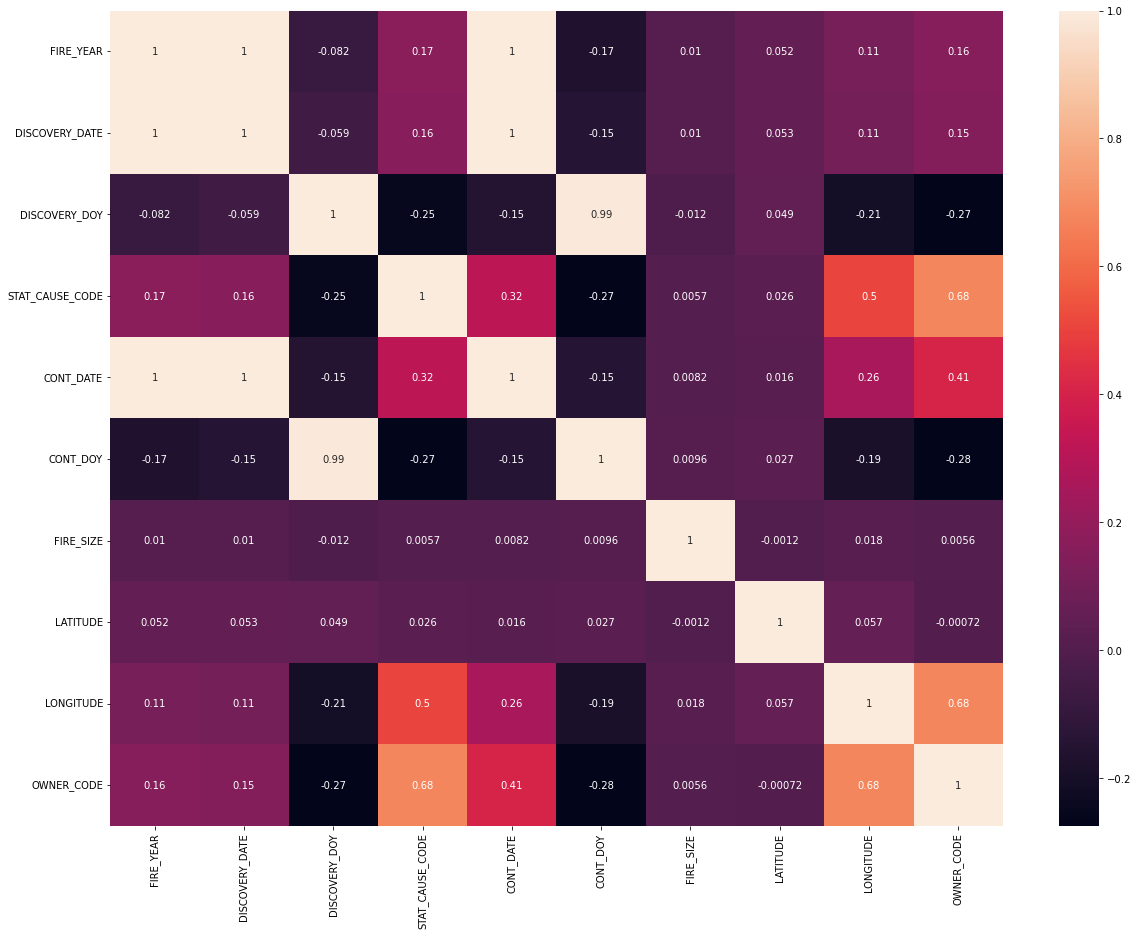

In [20]:
plt.subplots(figsize=(20,15))
sns.heatmap(data=correlation_matrix, annot=True)

### None of them seem to have a high correlation, so no additional action is needed here.

### Display data info and summary again

In [21]:
print(f"Rows {wildfires.shape[0]} X Columns {wildfires.shape[1]}")

Rows 34157 X Columns 17


In [22]:
wildfires.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34157 entries, 47 to 1860054
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FIRE_YEAR         34157 non-null  int64  
 1   DISCOVERY_DATE    34157 non-null  float64
 2   DISCOVERY_DOY     34157 non-null  int64  
 3   DISCOVERY_TIME    29449 non-null  object 
 4   STAT_CAUSE_CODE   34157 non-null  float64
 5   STAT_CAUSE_DESCR  34157 non-null  object 
 6   CONT_DATE         28325 non-null  float64
 7   CONT_DOY          28325 non-null  float64
 8   CONT_TIME         28165 non-null  object 
 9   FIRE_SIZE         34157 non-null  float64
 10  FIRE_SIZE_CLASS   34157 non-null  object 
 11  LATITUDE          34157 non-null  float64
 12  LONGITUDE         34157 non-null  float64
 13  OWNER_CODE        34157 non-null  float64
 14  COUNTY            19347 non-null  object 
 15  FIPS_CODE         19347 non-null  object 
 16  FIPS_NAME         19347 non-null  obj

In [23]:
round((wildfires.isnull().sum(axis = 0)/len(wildfires.index))*100 , 2)

FIRE_YEAR            0.00
DISCOVERY_DATE       0.00
DISCOVERY_DOY        0.00
DISCOVERY_TIME      13.78
STAT_CAUSE_CODE      0.00
STAT_CAUSE_DESCR     0.00
CONT_DATE           17.07
CONT_DOY            17.07
CONT_TIME           17.54
FIRE_SIZE            0.00
FIRE_SIZE_CLASS      0.00
LATITUDE             0.00
LONGITUDE            0.00
OWNER_CODE           0.00
COUNTY              43.36
FIPS_CODE           43.36
FIPS_NAME           43.36
dtype: float64

In [24]:
wildfires.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,COUNTY,FIPS_CODE,FIPS_NAME
47,2005,2453535.5,165,1300,1.0,Lightning,2453535.5,165.0,1530,0.5,B,39.292222,-105.183056,5.0,None,None,None
61,2005,2453520.5,150,1100,1.0,Lightning,2453521.5,151.0,1218,0.2,A,38.913333,-105.983611,5.0,None,None,None
62,2005,2453542.5,172,1241,4.0,Campfire,2453542.5,172.0,1506,0.1,A,39.100278,-106.367500,5.0,None,None,None
114,2005,2453558.5,188,1907,1.0,Lightning,2453558.5,188.0,2130,80.0,C,37.345000,-102.805833,5.0,None,None,None
205,2005,2453534.5,164,1428,9.0,Miscellaneous,2453534.5,164.0,1736,2.5,B,38.891111,-105.431944,13.0,None,None,None


In [25]:
wildfires_orig_copy = wildfires.copy()

## Clean individual columns

### "FIRE_YEAR"

In [26]:
wildfires['FIRE_YEAR'].value_counts()

2013    3894
2010    2694
1994    2515
2003    2422
2005    1875
2000    1619
1995    1517
1996    1405
1992    1322
2006    1316
2004    1310
2001    1266
1993    1244
2002    1221
2012    1106
2007    1070
2008    1015
2011     957
2009     952
1998     765
1999     756
1997     722
2014     603
2015     591
Name: FIRE_YEAR, dtype: int64

<AxesSubplot:xlabel='FIRE_YEAR', ylabel='count'>

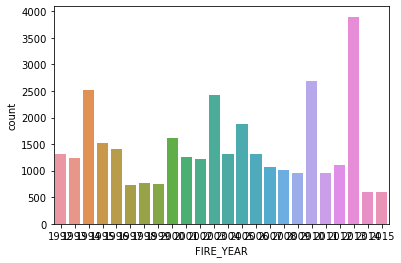

In [27]:
sns.countplot(x = 'FIRE_YEAR', data=wildfires)

#### Number of unique years where wildfires happened does not seem skewed or abnormal. Will leave this columns as it is.

### "DISCOVERY_DATE"

In [28]:
wildfires['DISCOVERY_DATE'].value_counts()

2449536.5    80
2449548.5    63
2449557.5    61
2450647.5    61
2452806.5    60
             ..
2453044.5     1
2453103.5     1
2453043.5     1
2453046.5     1
2457101.5     1
Name: DISCOVERY_DATE, Length: 5325, dtype: int64

/Users/aoadmin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DISCOVERY_DATE', ylabel='Density'>

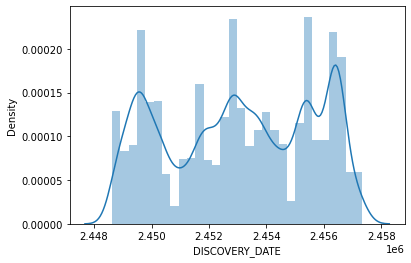

In [29]:
sns.distplot(wildfires['DISCOVERY_DATE'])

<AxesSubplot:xlabel='DISCOVERY_DATE'>

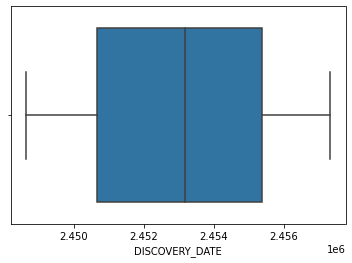

In [30]:
sns.boxplot(x = wildfires['DISCOVERY_DATE'])

#### This column also does not have missing values or outliers that need to be accounted for

### "DISCOVERY_DOY"

In [31]:
wildfires['DISCOVERY_DOY'].value_counts()

205    454
185    431
186    417
184    410
199    397
      ... 
353      4
365      4
356      3
358      2
355      2
Name: DISCOVERY_DOY, Length: 365, dtype: int64

<AxesSubplot:xlabel='DISCOVERY_DOY', ylabel='count'>

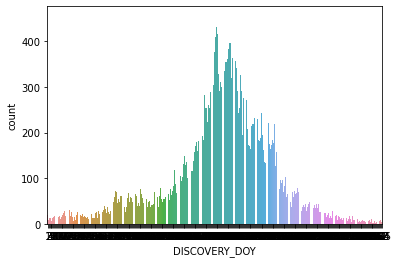

In [32]:
sns.countplot(x = 'DISCOVERY_DOY', data=wildfires)

#### A lot of thes fires occur in the summer in CO, so this plot makes sense. No missing values.

### "DISCOVERY_TIME"

### Convert values from objects to floats

In [33]:
wildfires[['DISCOVERY_TIME']] = wildfires[['DISCOVERY_TIME']].apply(pd.to_numeric)

In [34]:
wildfires['DISCOVERY_TIME'].value_counts()

1500.0    679
1400.0    673
1600.0    666
1700.0    545
1800.0    498
         ... 
215.0       1
551.0       1
2351.0      1
2322.0      1
602.0       1
Name: DISCOVERY_TIME, Length: 1258, dtype: int64

In [35]:
print(f"There are {wildfires['DISCOVERY_TIME'].isnull().sum(axis=0)} missing values. Fill in with most common one.")

There are 4708 missing values. Fill in with most common one.


In [36]:
wildfires['DISCOVERY_TIME'] = wildfires['DISCOVERY_TIME'].apply(lambda time: 1500.0 if np.isnan(time) else time)

/Users/aoadmin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DISCOVERY_TIME', ylabel='Density'>

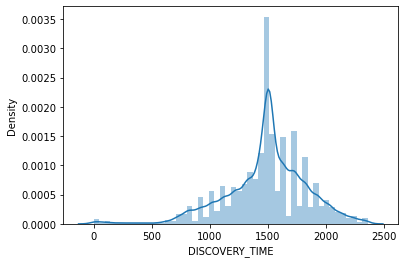

In [37]:
sns.distplot(wildfires['DISCOVERY_TIME'])

<AxesSubplot:xlabel='DISCOVERY_TIME'>

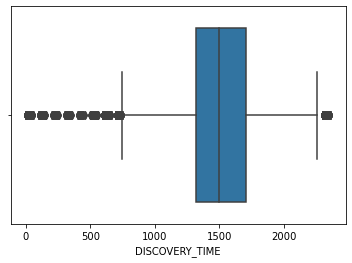

In [38]:
sns.boxplot(x = wildfires['DISCOVERY_TIME'])

### Handle outliers using the IQR method and replace values for a better distribution

In [39]:
Q3 = wildfires['DISCOVERY_TIME'].quantile(0.75)
Q1 = wildfires['DISCOVERY_TIME'].quantile(0.25)
IQR = Q3 - Q1
IQR_min = Q1 - 1.5*IQR
IQR_max = Q3 + 1.5*IQR

In [40]:
wildfires['DISCOVERY_TIME'].apply(lambda time: wildfires['DISCOVERY_TIME'].replace(time, IQR_min + 1, inplace=True) if (time < IQR_min) else time)

47         1300.0
61         1100.0
62         1241.0
114        1907.0
205        1428.0
            ...  
1860039    1519.0
1860043    1600.0
1860044    1121.0
1860048    1305.0
1860054    1312.0
Name: DISCOVERY_TIME, Length: 34157, dtype: float64

In [41]:
wildfires['DISCOVERY_TIME'].apply(lambda time: wildfires['DISCOVERY_TIME'].replace(time, IQR_max - 1, inplace=True) if (time > IQR_max) else time)

47         1300.0
61         1100.0
62         1241.0
114        1907.0
205        1428.0
            ...  
1860039    1519.0
1860043    1600.0
1860044    1121.0
1860048    1305.0
1860054    1312.0
Name: DISCOVERY_TIME, Length: 34157, dtype: float64

<AxesSubplot:xlabel='DISCOVERY_TIME'>

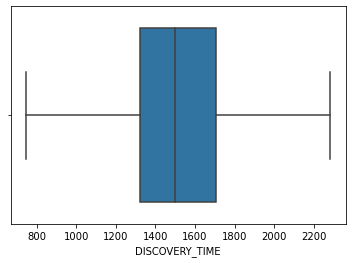

In [42]:
sns.boxplot(x = wildfires['DISCOVERY_TIME'])

### "STAT_CAUSE_CODE"

In [43]:
wildfires['STAT_CAUSE_CODE'].value_counts()

1.0     19945
9.0      4660
13.0     3113
4.0      2953
7.0       844
3.0       766
5.0       708
2.0       547
10.0      244
8.0       208
6.0       108
11.0       45
12.0       16
Name: STAT_CAUSE_CODE, dtype: int64

#### This column is the code indetifier for the cause, so duplicate information will be given. This column can be dropped.

In [44]:
wildfires.drop("STAT_CAUSE_CODE", axis=1, inplace=True)

### "STAT_CAUSE_DESCR"

In [45]:
wildfires['STAT_CAUSE_DESCR'].value_counts()

Lightning            19945
Miscellaneous         4660
Missing/Undefined     3113
Campfire              2953
Arson                  844
Smoking                766
Debris Burning         708
Equipment Use          547
Fireworks              244
Children               208
Railroad               108
Powerline               45
Structure               16
Name: STAT_CAUSE_DESCR, dtype: int64

<AxesSubplot:xlabel='STAT_CAUSE_DESCR', ylabel='count'>

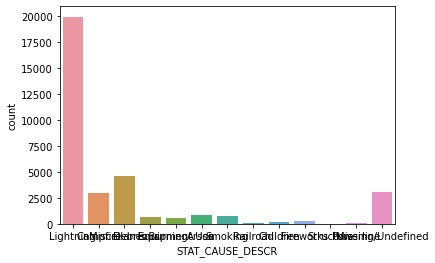

In [46]:
sns.countplot(x = 'STAT_CAUSE_DESCR', data=wildfires)

#### Merge categories other than lightning into one category

In [47]:
categories_to_merge = [category for category in set(wildfires['STAT_CAUSE_DESCR'].values) 
                       if category != "Lightning"]

wildfires['STAT_CAUSE_DESCR'].replace(categories_to_merge, 'Miscellaneous', inplace=True)

In [48]:
wildfires['STAT_CAUSE_DESCR'].value_counts()

Lightning        19945
Miscellaneous    14212
Name: STAT_CAUSE_DESCR, dtype: int64

### "CONT_DATE"

In [49]:
wildfires['CONT_DATE'].value_counts()

2450647.5    61
2453918.5    53
2453201.5    52
2452807.5    50
2453917.5    48
             ..
2455316.5     1
2455510.5     1
2450615.5     1
2455199.5     1
2457070.5     1
Name: CONT_DATE, Length: 4651, dtype: int64

In [50]:
print(f"There are {wildfires['CONT_DATE'].isnull().sum(axis=0)} missing values. Fill in with most common one.")

There are 5832 missing values. Fill in with most common one.


In [51]:
wildfires['CONT_DATE'] = wildfires['CONT_DATE'].apply(lambda date: 2450647.5 if np.isnan(date) else date)

### "CONT_DOY"

In [52]:
wildfires['CONT_DOY'].value_counts()

206.0    366
205.0    365
185.0    356
186.0    346
199.0    345
        ... 
360.0      1
353.0      1
359.0      1
361.0      1
342.0      1
Name: CONT_DOY, Length: 362, dtype: int64

In [53]:
print(f"There are {wildfires['CONT_DOY'].isnull().sum(axis=0)} missing values. Fill in with most common one.")

There are 5832 missing values. Fill in with most common one.


In [54]:
wildfires['CONT_DOY'] = wildfires['CONT_DOY'].apply(lambda day: 2450647.5 if np.isnan(day) else day)

### "CONT_TIME"

In [55]:
wildfires['CONT_TIME'].value_counts()

1800    1712
1200    1210
2000    1117
1700     769
1600     766
        ... 
0324       1
0345       1
0732       1
0503       1
0119       1
Name: CONT_TIME, Length: 1175, dtype: int64

In [56]:
print(f"There are {wildfires['CONT_TIME'].isnull().sum(axis=0)} missing values. Fill in with most common one.")

There are 5992 missing values. Fill in with most common one.


#### Change type of column data type from object/string to float

In [57]:
wildfires[['CONT_TIME']] = wildfires[['CONT_TIME']].apply(pd.to_numeric)

In [58]:
wildfires['CONT_TIME'] = wildfires['CONT_TIME'].apply(lambda time: 1800 if np.isnan(time) else time)

### "FIRE_SIZE"

In [59]:
wildfires['FIRE_SIZE'].value_counts()

0.1        22644
0.3         1479
1.0         1431
0.5         1371
0.2         1271
           ...  
11032.0        1
747.0          1
661.9          1
1589.0         1
11699.0        1
Name: FIRE_SIZE, Length: 855, dtype: int64

/Users/aoadmin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='FIRE_SIZE', ylabel='Density'>

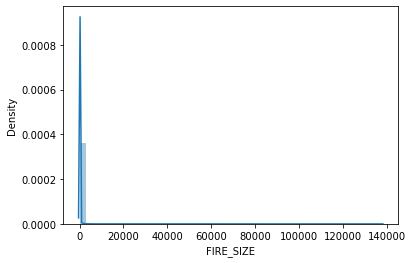

In [60]:
sns.distplot(wildfires['FIRE_SIZE'])

<AxesSubplot:xlabel='FIRE_SIZE'>

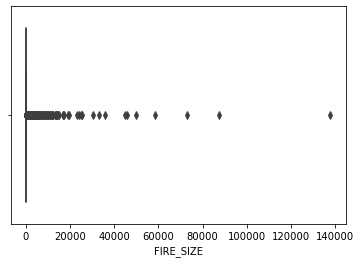

In [61]:
sns.boxplot(x = wildfires['FIRE_SIZE'])

#### Distribution looks very skewed with evident outliers. Column also focuses on area covered by fire in ters of size and not location. Therefore, this column could be used more as a depedent variable than independent variable.

In [62]:
wildfires.drop("FIRE_SIZE", axis=1, inplace=True)

### "FIRE_SIZE_CLASS"

#### This class could be better used to avoid outliers and still get idea of fire size.

In [63]:
wildfires['FIRE_SIZE_CLASS'].value_counts()

A    24413
B     7495
C     1387
D      362
E      271
F      161
G       68
Name: FIRE_SIZE_CLASS, dtype: int64

<AxesSubplot:xlabel='FIRE_SIZE_CLASS', ylabel='count'>

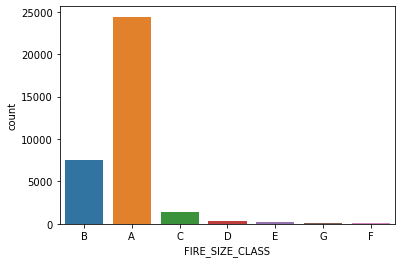

In [64]:
sns.countplot(x = 'FIRE_SIZE_CLASS', data=wildfires)

### Merge other classes that are not the most common A class for better distribution in this column.

In [65]:
other_fire_size_classes = [fire_size_class for fire_size_class in set(wildfires['FIRE_SIZE_CLASS'].values)
                           if fire_size_class != "A"]

wildfires['FIRE_SIZE_CLASS'].replace(other_fire_size_classes, 'Other', inplace=True)

<AxesSubplot:xlabel='FIRE_SIZE_CLASS', ylabel='count'>

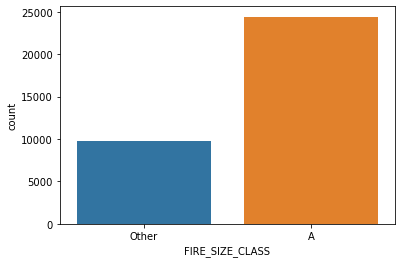

In [66]:
sns.countplot(x = 'FIRE_SIZE_CLASS', data=wildfires)

### "LATITUDE"

In [67]:
wildfires['LATITUDE'].value_counts()

39.8666    73
40.0997    68
39.8833    67
39.6000    65
39.9500    64
           ..
39.2633     1
39.3608     1
39.6305     1
39.6441     1
40.8198     1
Name: LATITUDE, Length: 18007, dtype: int64

/Users/aoadmin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LATITUDE', ylabel='Density'>

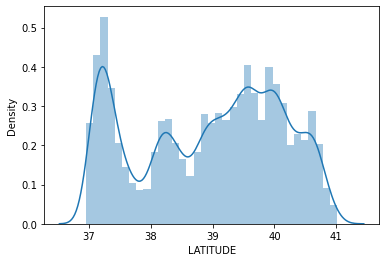

In [68]:
sns.distplot(wildfires['LATITUDE'])

<AxesSubplot:xlabel='LATITUDE'>

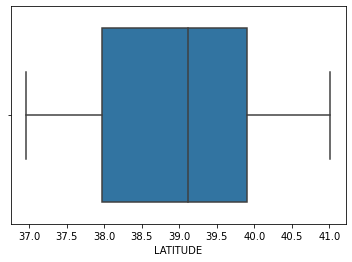

In [69]:
sns.boxplot(x = wildfires['LATITUDE'])

#### No outliers, missing values, or problems with distribution.

### "LONGITUDE"

In [70]:
wildfires['LONGITUDE'].value_counts()

-108.48400    78
-104.80650    71
-108.41730    69
-108.38400    66
-108.36730    65
              ..
-107.91840     1
-107.54192     1
-108.08420     1
-107.54010     1
-105.08470     1
Name: LONGITUDE, Length: 19449, dtype: int64

/Users/aoadmin/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LONGITUDE', ylabel='Density'>

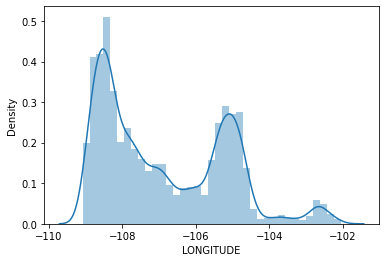

In [71]:
sns.distplot(wildfires['LONGITUDE'])

<AxesSubplot:xlabel='LONGITUDE'>

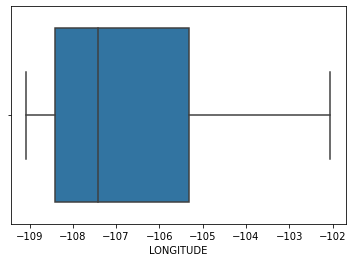

In [72]:
sns.boxplot(x = wildfires['LONGITUDE'])

#### No outliers, missing values, or problems with distribution.

### "OWNER_CODE"

In [73]:
wildfires['OWNER_CODE'].value_counts()

1.0     10582
14.0     9320
5.0      8176
2.0      2784
8.0      1624
3.0       999
13.0      245
7.0       198
6.0        78
4.0        72
11.0       45
12.0       15
9.0        13
15.0        5
10.0        1
Name: OWNER_CODE, dtype: int64

<AxesSubplot:xlabel='OWNER_CODE', ylabel='count'>

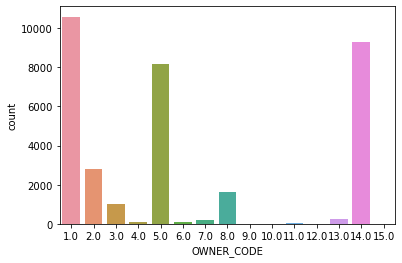

In [74]:
sns.countplot(x = 'OWNER_CODE', data=wildfires)

<AxesSubplot:xlabel='OWNER_CODE'>

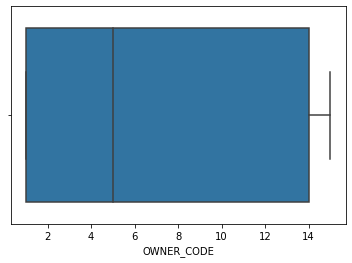

In [75]:
sns.boxplot(x = wildfires['OWNER_CODE'])

#### No outliers, missing values, or problems with distribution.

### "COUNTY"

#### County is the same information as FIPS code, so will drop this column.

In [76]:
wildfires.drop("COUNTY", axis=1, inplace=True)

### "FIPS_CODE"

### This is the independent variable!

In [77]:
wildfires['FIPS_CODE'].value_counts()

103    1901
081    1609
077    1586
045    1209
085    1083
       ... 
095       6
115       3
073       2
023       1
031       1
Name: FIPS_CODE, Length: 63, dtype: int64

<AxesSubplot:xlabel='FIPS_CODE', ylabel='count'>

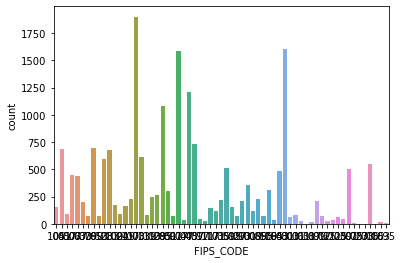

In [78]:
sns.countplot(x = 'FIPS_CODE', data=wildfires)

#### Looks fairly distributed, so will only handle missing values.

In [79]:
print(f"There are {wildfires['FIPS_CODE'].isnull().sum(axis=0)} missing values.")

There are 14810 missing values.


In [80]:
print(f"{round(wildfires['FIPS_CODE'].isnull().sum(axis=0) / wildfires.shape[0], 2)} of the dataset has missing FIPS code value.")

0.43 of the dataset has missing FIPS code value.


#### If we don't know the independent variable value, then it is not helpful for the supervised models to fit which is a big cut in this case. We will be cutting the rows from the dataset, but a more complicated approach can be taken. It is to use the latitudes and longitudes to get the geolocation of the county and thus the FIPS code. This will be discussed internally within the group to see if time and knowledge constraints allow this approach.

In [81]:
print(f"Rows {wildfires.shape[0]} X Columns {wildfires.shape[1]} before.")

Rows 34157 X Columns 14 before.


In [82]:
wildfires.dropna(subset=['FIPS_CODE'], inplace=True)

In [83]:
print(f"Rows {wildfires.shape[0]} X Columns {wildfires.shape[1]} after.")

Rows 19347 X Columns 14 after.


In [84]:
wildfires[['FIPS_CODE']] = wildfires[['FIPS_CODE']].apply(pd.to_numeric)

### "FIPS_NAME"

#### This column has the actual name of the county that the FIPS code refers to. Therefore, this column is duplicate information, but can be used to get a human-readable name.

In [85]:
fips_names = wildfires["FIPS_NAME"].copy()

In [86]:
wildfires.drop("FIPS_NAME", axis=1, inplace=True)

### Creating dummy variables for categorical variables

In [87]:
dummy_columns_labels = ['STAT_CAUSE_DESCR', 'FIRE_SIZE_CLASS']
dummy_columns = pd.get_dummies(wildfires[dummy_columns_labels], drop_first=True)

In [88]:
wildfires = pd.concat([wildfires, dummy_columns], axis=1)

In [89]:
wildfires.drop(dummy_columns_labels, axis=1, inplace=True)

### Display data one last time

In [90]:
wildfires.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19347 entries, 1037 to 1860054
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   FIRE_YEAR                       19347 non-null  int64  
 1   DISCOVERY_DATE                  19347 non-null  float64
 2   DISCOVERY_DOY                   19347 non-null  int64  
 3   DISCOVERY_TIME                  19347 non-null  float64
 4   CONT_DATE                       19347 non-null  float64
 5   CONT_DOY                        19347 non-null  float64
 6   CONT_TIME                       19347 non-null  float64
 7   LATITUDE                        19347 non-null  float64
 8   LONGITUDE                       19347 non-null  float64
 9   OWNER_CODE                      19347 non-null  float64
 10  FIPS_CODE                       19347 non-null  int64  
 11  STAT_CAUSE_DESCR_Miscellaneous  19347 non-null  uint8  
 12  FIRE_SIZE_CLASS_Other      

In [91]:
round((wildfires.isnull().sum(axis = 0)/len(wildfires.index))*100 , 2)

FIRE_YEAR                         0.0
DISCOVERY_DATE                    0.0
DISCOVERY_DOY                     0.0
DISCOVERY_TIME                    0.0
CONT_DATE                         0.0
CONT_DOY                          0.0
CONT_TIME                         0.0
LATITUDE                          0.0
LONGITUDE                         0.0
OWNER_CODE                        0.0
FIPS_CODE                         0.0
STAT_CAUSE_DESCR_Miscellaneous    0.0
FIRE_SIZE_CLASS_Other             0.0
dtype: float64

In [92]:
wildfires.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,CONT_DATE,CONT_DOY,CONT_TIME,LATITUDE,LONGITUDE,OWNER_CODE,FIPS_CODE,STAT_CAUSE_DESCR_Miscellaneous,FIRE_SIZE_CLASS_Other
1037,2005,2453428.5,58,1600.0,2453429.5,59.0,1300.0,37.720833,-106.698611,5.0,105,1,0
2171,2005,2453598.5,228,1730.0,2453598.5,228.0,2006.0,39.081944,-104.894722,5.0,41,0,0
2366,2005,2453582.5,212,1830.0,2453583.5,213.0,1400.0,40.580833,-106.602222,5.0,57,0,0
2799,2005,2453508.5,138,1500.0,2453508.5,138.0,1557.0,37.155833,-107.091667,5.0,7,1,0
2815,2005,2453524.5,154,1830.0,2453526.5,156.0,1630.0,37.466111,-107.878056,5.0,67,0,1


#### In this case, the values for the first columns that were dropped for the dummy columns are: 
#### STAT_CAUSE_DESCR_Lightning and FIRE_SIZE_CLASS_A

## Create models

### Determine Xs and Y

In [93]:
y = wildfires['FIPS_CODE']

In [94]:
X = wildfires.drop(['FIPS_CODE'], axis=1)

### Partition Data

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Model 1: 